In [215]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn.cross_validation import KFold, cross_val_score, cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [1901]:
directory = "/Users/mjaron/Google Drive/QMSS/translational_bioinformatics/Research Project/Data/"
variables = pd.read_csv(directory+'variables_master.csv')
independent_variables = variables[variables['ind_dependent'] == 'independent']
dependent_variables = variables[variables['ind_dependent'] == 'dependent']

## creating a basic dictionary for lookup
var_dict = {}
for count, name in enumerate(variables['name']): 
    var_dict[str(name)] = {'label':variables['label'][count],
                               'file': variables['file'][count],
                               'year':variables['years'][count],
                                'var_type': 'na',  ##could add type, i.e. range of values, code, binary, etc
                                'ind_dep': variables['ind_dependent'][count]}

## using this to find the exact variables for each file
file_var_dict = {}
for count, file_ in enumerate(variables['file']):
    temp_df = variables[variables['file'] == file_]
    var_list = temp_df['name']
    year_list = temp_df['years']
    file_var_dict[file_] = {'variables':list(var_list), 'year':list(year_list)}


## getting actual data and reading into dict                  
data_dict = {}
for file_ in os.listdir(directory+'Demographic/'):
    if '.XPT' in file_:
        temp_df = pd.read_sas(directory+'Demographic/'+file_)
        data_dict[file_[:-4]] = temp_df

        
file_abr = list(set(variables['file']))
# print data_dict.keys()

In [1902]:
## create a filtered data dictionary where now it narrows down to varialbes I only car about plus adding in year
## Gets entire df and just select columns needed, then adds in the year for each row.

filt_data_dict = {}
for name in data_dict.keys():
    for abr in file_abr:
        if abr in name:
            temp_df = pd.DataFrame()
            columns = file_var_dict[abr]['variables']
            for i in columns:
#                 print i
                ## hard coded in this as the variable changes name slightly from 11'-14' but pretty much same
                i1 = i
                if i == 'ACD011A':
                    i1 = 'ACD010A'
                elif i == 'ACD011B':
                    i1 = 'ACD010B'
                elif i == 'DMDBORN4' or i == 'DMDBORN2':
                    i1= 'DMDBORN'
                elif i == 'HIQ011':
                    i1= 'HID010'
                elif i == 'OCD180':
                    i1= 'OCQ180'
                try:
                    temp_df[i1] = data_dict[name][i]
                except:
                    continue
                    
#             temp_df[file_+'_year'] = [name for years in range(0,len(temp_df))] ## might not be necessary
            temp_df['SEQN'] =  data_dict[name]['SEQN']
            filt_data_dict[name] = temp_df
# print filt_data_dict.keys()

In [1903]:
# RIDRETH1
# print var_dict['RIDRETH1']

In [1904]:
## combine years for all same files and variables, since SEQN for each year seems to be unique

## initiate dict
combinded_var_dict ={}
for i in filt_data_dict.keys():
    for abr in file_abr:
        if abr in i:
            combinded_var_dict[abr] = pd.DataFrame()

## combine all years together for each variable
dep_list = list(dependent_variables['file'])
for i in filt_data_dict.keys():
    for abr in file_abr:
        if abr in i:
            combinded_var_dict[abr] = combinded_var_dict[abr].append(filt_data_dict[i])
            if abr in dep_list:
                combinded_var_dict[abr] = combinded_var_dict[abr].dropna()
            combinded_var_dict[abr].reset_index(drop=True, inplace=True)
    

In [1905]:
def clean(col, max_, max_val=np.nan, min_=0, min_val=np.nan, keep_na=True, \
              remove=False, rem_var=99, rem_rep_var=np.nan):
    '''
    input:
        column
    arguments:
        lots of different ways to clean the column, with mostly preset info
    output:
        column
    '''
    col.loc[(col > max_)] = max_val
    col.loc[(col < min_)] = min_val
    if keep_na == False:
        col = col.fillna(value=0)  
    if remove == True:
        col.loc[(col == rem_var)] = rem_rep_var
            
    return col

#         df['ACD010B'] = df['ACD010B'].where(df['ACD010B'] != 8, 1)

In [1906]:
# print combinded_var_dict.keys()
# print combinded_var_dict['ACQ']['ACD010B']

In [1907]:
## now clean data based on each uniqe variable
## look at each set of variables 1 by 1 and edit if needed

'''
*ACD01** = 1 or 0, make any # > 1 = na, na = 0

*DMDBORN = 1 or 0, make any # > 1 = na
DMDHHSIZ = 1-7, 7 is 7 or more
*DMDEDUC2 & DMDEDUC3 prob should be combined 
*DMDEDUC2 = 1-5 good, 6 or more = na
*DMDEDUC3 = 1-15 good, 16 or more = na
DMDHHSZA = 0-3 good
DMDHHSZB = 0-4, 4 is 4 or more
DMDHHSZE = 0-3, 3 is 3 or more
*DMDHSEDU = 1-5 good, 6 or more = na
*DMDMARTL = 1-6 good, 6 or greater *** not linear, each val is diff, prob need to split up into indiv binary columns
*INDFMIN2 = 1-15 (not 12 & 13), good
*RIAGENDR = 1-2 good *** categorical, needs to be split up
RIDAGEYR = 0-80 good

*HID010 = 1 yes , 2 no, change to 1 yes , 0 no

LBXIN = range, good 

*OCD150 = 1 is working, anything above basically not working make 0
*OCQ180 = 1 to 133
'''

for i in combinded_var_dict:
    if 'ACQ' in i:
        df = combinded_var_dict[i]
        df['ACD010A'] = clean(df['ACD010A'], max_= 1, max_val=0, keep_na=False)
        df['ACD010B'] = clean(df['ACD010B'], max_= 7, max_val=1, keep_na=False)
        combinded_var_dict[i] = df
        
    elif 'DEMO' in i:
        df = combinded_var_dict[i]
        df['DMDBORN'] = clean(df['DMDBORN'], max_= 1, max_val=0)
        df['DMDEDUC2'] = clean(df['DMDEDUC2'], max_= 6)
        df['DMDEDUC3'] = clean(df['DMDEDUC3'], max_= 16, remove=True, rem_var=14)
        df['DMDHSEDU'] = clean(df['DMDHSEDU'], max_= 5)

        ## split up below categorical variable
        df['DMDMARTL'] = clean(df['DMDMARTL'], max_= 6, keep_na=False)
        new_var_list = ['Missing', 'Married', 'Widowed', 'Divorced', 'Separated', 'Never_married', 'Living_with_partner']
        for item in range(0,7):
            ## create empty list of 0 with same len
            df['DMDMARTL_'+new_var_list[item]] = [0]*len(df['DMDMARTL']) 
            ## find the index of each item = to the number
            df['DMDMARTL_'+new_var_list[item]].loc[(df['DMDMARTL'] == item)] = 1
        ## get rid of the original column now since it has been split up    
        df.drop('DMDMARTL', axis=1, inplace=True)
        
#         new_var_list = ['Male', 'Female']
#         for item in range(1,3):
#             ## create empty list of 0 with same len
#             df['RIAGENDR_'+new_var_list[item-1]] = [0]*len(df['RIAGENDR']) 
#             ## find the index of each item = to the number
#             df['RIAGENDR_'+new_var_list[item-1]].loc[(df['RIAGENDR'] == item)] = 1
#         ## get rid of the original column now since it has been split up    
#         df.drop('RIAGENDR', axis=1, inplace=True)
        
        df['INDFMIN2'] = clean(df['INDFMIN2'], max_= 15, remove=True, rem_var=12)
        df['INDFMIN2'].loc[(df['INDFMIN2'] == 13)] = np.nan
        combinded_var_dict[i] = df
        
    elif 'HIQ' in i:
        df = combinded_var_dict[i]
        df['HID010'] = clean(df['HID010'], max_= 2, remove=True, rem_var=2, rem_rep_var=0)
        combinded_var_dict[i] = df
        
    elif 'L10AM' in i:
        continue
        
    elif 'OCQ' in i:
        df = combinded_var_dict[i]
        df['OCD150'] = clean(df['OCD150'], max_= 1, max_val=0)
        df['OCQ180'] = clean(df['OCQ180'], max_= 133)
        combinded_var_dict[i] = df


In [1908]:
# get kernuys cleaned data and at it all together, for independent variables
new_master = pd.DataFrame() 
for files in os.listdir(directory+'cleaned_data/'):
    if '.csv' in files:
        temp_df = pd.read_csv(directory+'cleaned_data/'+files)
        temp_df.drop('Unnamed: 0', axis=1, inplace=True)
        temp_df.drop('year', axis=1, inplace=True)
        new_master = new_master.append(temp_df)
        new_master = new_master.reset_index(drop=True)

new_master['SEQN'] = new_master['seqn']
new_master.drop('seqn', axis=1, inplace=True)

## when ready add to main df
combinded_var_dict['other'] = new_master

print new_master.columns.tolist()
print new_master.shape
print combinded_var_dict.keys()

for i in new_master.columns.tolist():
    print i
    print new_master[i].describe()
    print '\n'

'''
'alq120q', 'alq130', duplicates
bpq100b, maybe to telling
imq030, maybe to telling, vaccine
'''

['alq120q', 'alq130', 'bmxbmi', 'bmxwaist', 'hsq520', 'paq180', 'paq670', 'paqiaf_number', 'paqiaf_totalmet', 'smq040', 'whd020', 'whd110', 'whd120', 'whq150', 'SEQN']
(81710, 15)
['HIQ', 'DEMO', 'L10AM', 'ACQ', 'other', 'OCQ', 'BPX']
alq120q
count    32552.000000
mean         4.097874
std         18.913073
min          0.000000
25%               NaN
50%               NaN
75%               NaN
max        365.000000
Name: alq120q, dtype: float64


alq130
count    25064.000000
mean         3.764443
std         29.776993
min          1.000000
25%               NaN
50%               NaN
75%               NaN
max        999.000000
Name: alq130, dtype: float64


bmxbmi
count    71038.000000
mean        25.307827
std          7.492891
min          7.990000
25%               NaN
50%               NaN
75%               NaN
max        130.210000
Name: bmxbmi, dtype: float64


bmxwaist
count    68785.00000
mean        86.13201
std         21.72152
min         32.00000
25%              NaN
50%    

"\n'alq120q', 'alq130', duplicates\nbpq100b, maybe to telling\nimq030, maybe to telling, vaccine\n"

In [1909]:
### get kernyus dependent variables
dependent_var_clean = pd.DataFrame() 
for files in os.listdir(directory+'cleaned_data/dependent/'):
    if '.csv' in files:
        temp_df = pd.read_csv(directory+'cleaned_data/dependent/'+files)
        temp_df.drop('Unnamed: 0', axis=1, inplace=True)
        temp_df.drop('year', axis=1, inplace=True)
        dependent_var_clean = dependent_var_clean.append(temp_df)
        dependent_var_clean = dependent_var_clean.reset_index(drop=True)

dependent_var_clean['SEQN'] = dependent_var_clean['seqn']
dependent_var_clean.drop('seqn', axis=1, inplace=True)
dependent_var_clean.drop('lbxinsi', axis=1, inplace=True)
dependent_var_clean.drop('lbxin', axis=1, inplace=True)
## add in my cleaned column
print dependent_var_clean.shape
dependent_var_clean = dependent_var_clean.merge(combinded_var_dict['L10AM'], on='SEQN', how='inner')
dependent_var_clean = dependent_var_clean.merge(combinded_var_dict['BPX'], on='SEQN', how='inner')
# temp_bp1 = dependent_var_clean
# temp_bp1 = temp_bp1.merge(combinded_var_dict['BPX'], on='SEQN', how='inner')

print combinded_var_dict['BPX'].shape, 'here'
print combinded_var_dict['L10AM'].shape
print dependent_var_clean.shape
print dependent_var_clean.head()
# print new_master.sort('SEQN', ascending=False).head()
# print combinded_var_dict['L10AM'].sort('SEQN', ascending=False).head()
## when ready add to main df
# combinded_var_dict['other'] = new_master

(23925, 7)
(55128, 4) here
(24963, 2)
(21486, 11)
   lbdldl  lbxsca  lbxsch  lbxsgl  lbxsir  lbxstr  SEQN  LBXIN  BPXSY1  \
0     136     9.3     203      78      63     115     2   4.55   106.0   
1     168     9.5     277      95     137     341     5  13.65   122.0   
2     127     9.8     244      81      95      57     7   9.72   130.0   
3      80     9.4     135      87      80      42    10   6.43   152.0   
4      77    10.2     134      88      89      72    11  11.99   110.0   

   BPXDI1  BPXPLS  
0    58.0    68.0  
1    82.0    66.0  
2    78.0    58.0  
3    98.0    58.0  
4    52.0    62.0  


In [1910]:
# prob can merge on SEQN since each year seems to be unique, and only merge all independent variables
master = combinded_var_dict['ACQ']
for df_name in combinded_var_dict: 
    if 'ACQ' not in df_name and df_name not in dep_list:
        master = master.merge(combinded_var_dict[df_name], on='SEQN', how='outer')
print master.shape
# print master.describe()
# print master['DMDHHSZA'].mean()

(82091, 39)


In [1911]:
## merge each df with each dependent variable to now use for the model
model_data_dict = {}
for i in dependent_var_clean.columns.tolist():
    if i != 'SEQN':
        temp_dep_df = pd.DataFrame()
#         if i == 'BPXSY1' or i == 'BPXDI1' or i == 'BPXPLS':
#             temp_dep_df['SEQN'] = combinded_var_dict['BPX']['SEQN']
#             temp_dep_df[i] = combinded_var_dict['BPX'][i]
#             model_data_dict[i] = master.merge(temp_dep_df, on='SEQN', how='inner')
#             print model_data_dict[i].shape
#         else:
#             temp_dep_df['SEQN'] = dependent_var_clean['SEQN']
#             temp_dep_df[i] = dependent_var_clean[i]
#             model_data_dict[i] = master.merge(temp_dep_df, on='SEQN', how='inner')
#             print model_data_dict[i].shape
        temp_dep_df['SEQN'] = dependent_var_clean['SEQN']
        temp_dep_df[i] = dependent_var_clean[i]
        model_data_dict[i] = master.merge(temp_dep_df, on='SEQN', how='inner')
        print model_data_dict[i].shape

# for i in dependent_variables['file']:
#     print i
#     var = combinded_var_dict[i].columns.tolist()
#     print var
#     model_data_dict[var[0]] = master.merge(combinded_var_dict[i], on='SEQN', how='inner')
#     print model_data_dict[var[0]].shape
print model_data_dict.keys()

(21486, 40)
(21486, 40)
(21486, 40)
(21486, 40)
(21486, 40)
(21486, 40)
(21486, 40)
(21486, 40)
(21486, 40)
(21486, 40)
['lbdldl', 'lbxsch', 'lbxsgl', 'lbxsca', 'lbxstr', 'LBXIN', 'BPXDI1', 'BPXPLS', 'BPXSY1', 'lbxsir']


In [1912]:
# model_data_dict['lbdldl']['DMDMARTL_Widowed'].describe()

In [1913]:
## get rid of outliers
for i in model_data_dict:
    df = model_data_dict[i]
    for col in df.columns.tolist():
        #keep only the ones that are within +3 to -3 standard deviations in the column
        df[col].loc[np.abs(df[col]-df[col].mean()) > (3*df[col].std())] = np.nan
#         df = df[np.abs(df[col]-df[col].mean())<=(3*df[col].std())] 
    model_data_dict[i] = df
#     print df.shape()

In [1914]:
## fill nan, using mean of entire column for now

for i in model_data_dict:
    print i
    col_length = []
    df = model_data_dict[i]
    df.reset_index(drop=True, inplace=True)
#     imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
#     imp.fit_transform(X)
    for col in model_data_dict[i]:
        perc = float(len(df[col].dropna()))/len(df)
        print col, len(df[col].dropna()), len(df), perc
        na_val = np.mean(df[col])
        
        ## find ~2000 rows with the least na's
#         row_count = df.count(axis=1)
#         row_count.sort_values(ascending=False, inplace=True)
#         row_count = row_count.reset_index()
#         ## get only top 2000 rows
#         row_index = list(row_count['index'][:4000])
        
        ## threshold to get rid of columns if missing to much data
        if np.isnan(na_val) or perc <= .4:
            print "dropped ", col
            df.drop(col, axis=1, inplace=True)
        else:
            df[col].fillna(na_val, inplace=True)
        ## now after replacement and threshold keep only top 2000 rows with least NA's calculated abovee
#     df = df.loc[row_index]
#     df = df.sample(n=2000)
        
    df.reset_index(drop=True, inplace=True)
    model_data_dict[i] = df

    

lbdldl
ACD010A 21486 21486 1.0
ACD010B 21437 21486 0.99771944522
SEQN 21486 21486 1.0
HID010 7566 21486 0.352136274784
dropped  HID010
DMDBORN 15644 21486 0.72810201992
DMDEDUC2 16172 21486 0.752676161221
DMDEDUC3 5151 21486 0.239737503491
dropped  DMDEDUC3
DMDHHSIZ 21486 21486 1.0
DMDHHSZA 5339 21486 0.248487387136
dropped  DMDHHSZA
DMDHHSZB 5394 21486 0.251047193521
dropped  DMDHHSZB
DMDHHSZE 5349 21486 0.248952806479
dropped  DMDHHSZE
DMDHSEDU 10682 21486 0.497160942009
INDFMIN2 10310 21486 0.479847342456
RIAGENDR 21486 21486 1.0
RIDAGEYR 21486 21486 1.0
RIDRETH1 21486 21486 1.0
DMDMARTL_Missing 21486 21486 1.0
DMDMARTL_Married 21486 21486 1.0
DMDMARTL_Widowed 20125 21486 0.936656427441
DMDMARTL_Divorced 19925 21486 0.927348040585
DMDMARTL_Separated 20958 21486 0.975425858699
DMDMARTL_Never_married 21486 21486 1.0
DMDMARTL_Living_with_partner 20234 21486 0.941729498278
alq120q 13102 21486 0.609792422973
alq130 10239 21486 0.476542865121
bmxbmi 20982 21486 0.976542865121
bmxwaist 208

In [1915]:
# temp = pd.DataFrame({'a':[1,2,3,4,5,np.nan,6], 'b':[2,3,4,6,np.nan,np.nan,9]})
# a = temp.count(axis=1)
# print a.sort_values(ascending=False, inplace=True)
# print a
# b = a.reset_index()
# k = list(b['index'][:3])
# print k
# print temp.loc[k]



In [1916]:
## find out which variables correlate with the dependent var

## general features to remove for all
# features_to_remove = ['ACD010B', 'DMDMARTL_Widowed', 'DMDMARTL_Divorced', 'DMDMARTL_Separated', \
#                       'DMDMARTL_Living_with_partner', 'DMDMARTL_Missing']

print model_data_dict.keys()

for i in model_data_dict:
    print i
#     try:
#         model_data_dict[i] = model_data_dict[i].drop(features_to_remove, axis=1)
#     except:
#         pass
    df = model_data_dict[i]
    a = df.corr()
#     print a
#     b = a[i]
#     print b.sort(ascending=True, kind='quicksort', na_position='last', inplace=False)
    high = []
    for col in df.columns.tolist():
        b = a[col]
        b = b.reset_index()
        for count,x in enumerate(b[col]):
            if abs(x) > .2 and abs(x) != 1:
                high.append((col,b['index'][count],x))
    print '*********************'
    break
print high
# plt.scatter(model_data_dict['lbdldl']['RIAGENDR'],model_data_dict['lbdldl']['whd120'])
# a = model_data_dict['lbdldl']['lbdldl']
# b = model_data_dict['lbxsch']['lbxsch']
# c = model_data_dict['lbxstr']['lbxstr']
# print '\n'
# print np.corrcoef(a,b)
# print np.corrcoef(a,c)
# print np.corrcoef(b,c)

['lbdldl', 'lbxsch', 'lbxsgl', 'lbxsca', 'lbxstr', 'LBXIN', 'BPXDI1', 'BPXPLS', 'BPXSY1', 'lbxsir']
lbdldl
*********************
[('ACD010A', 'DMDBORN', 0.48940780797516448), ('ACD010A', 'DMDEDUC2', 0.23565084101388109), ('ACD010A', 'DMDHHSIZ', -0.26548654255472803), ('ACD010A', 'DMDHSEDU', 0.23917285579492448), ('ACD010A', 'RIDRETH1', 0.64585869293619291), ('DMDBORN', 'ACD010A', 0.48940780797516448), ('DMDEDUC2', 'ACD010A', 0.23565084101388109), ('DMDEDUC2', 'DMDHSEDU', 0.47665724667575321), ('DMDEDUC2', 'INDFMIN2', 0.26516757841584748), ('DMDEDUC2', 'RIDRETH1', 0.24866269046246328), ('DMDHHSIZ', 'ACD010A', -0.26548654255472803), ('DMDHHSIZ', 'RIDAGEYR', -0.47135347448408693), ('DMDHHSIZ', 'DMDMARTL_Missing', 0.24161915309470589), ('DMDHHSIZ', 'whq150', -0.25863935104573132), ('DMDHSEDU', 'ACD010A', 0.23917285579492448), ('DMDHSEDU', 'DMDEDUC2', 0.47665724667575321), ('DMDHSEDU', 'INDFMIN2', 0.26667745009413135), ('DMDHSEDU', 'RIDRETH1', 0.25863768066327847), ('INDFMIN2', 'DMDEDUC2', 

In [1917]:
## correlations
'''
[('RIDAGEYR', 'whq150', 0.63273907024842002), ('bmxbmi', 'bmxwaist', 0.86370485543272124), 
('bmxbmi', 'whd020', 0.66453481733176267), ('bmxwaist', 'bmxbmi', 0.86370485543272124), 
('bmxwaist', 'whd020', 0.67986006498703533), ('whd020', 'bmxbmi', 0.66453481733176267), 
('whd020', 'bmxwaist', 0.67986006498703533), ('whd020', 'whd110', 0.56738619317411143), 
('whd020', 'whd120', 0.542019736144144), ('whd110', 'whd020', 0.56738619317411143), 
('whd110', 'whd120', 0.6215479165156752), ('whd120', 'whd020', 0.542019736144144), 
('whd120', 'whd110', 0.6215479165156752), ('whq150', 'RIDAGEYR', 0.63273907024842002)]
'''
## variables to remove
## after the 3rd row is experimentation
features_to_remove = ['DMDEDUC3', 'ACD010B', 'DMDMARTL_Widowed', 'DMDMARTL_Missing', 
                      'DMDMARTL_Divorced','DMDMARTL_Separated', 'DMDMARTL_Living_with_partner', 'hsq520', 
                      'bmxwaist', 'whd020', 'whq150', 'whd110', ## > 50% correlation with other variables
                     'DMDMARTL_Never_married', 'DMDHSEDU', 'DMDHHSIZ', 'DMDBORN'  ## > 40% correlation
                     ]

print model_data_dict.keys()

for i in model_data_dict:
    print i
    print model_data_dict[i].shape
#     print model_data_dict[i].columns.tolist()
    for var in features_to_remove:
        try:
            model_data_dict[i] = model_data_dict[i].drop(var, axis=1)
        except:
#             print "didnt drop ", var
            pass

['lbdldl', 'lbxsch', 'lbxsgl', 'lbxsca', 'lbxstr', 'LBXIN', 'BPXDI1', 'BPXPLS', 'BPXSY1', 'lbxsir']
lbdldl
(21486, 31)
lbxsch
(21486, 31)
lbxsgl
(21486, 31)
lbxsca
(21486, 31)
lbxstr
(21486, 31)
LBXIN
(21486, 31)
BPXDI1
(21486, 31)
BPXPLS
(21486, 31)
BPXSY1
(21486, 31)
lbxsir
(21486, 31)


In [1919]:
### turn into classification model, requires more knowledge of data
'''
http://www.healthline.com/health/high-cholesterol/levels-by-age#3
lbdldl
LDL
Good: 130 mg/dL or lower  (0)
Borderline: 130 to 159 mg/dL   (1)
High: 160 mg/dL or higher   (2)

lbxsch
Total Cholesterol
Good: 200 mg/dL or lower   (0)
Borderline: 200 to 239 mg/dL   (1)
High: 240 mg/dL or higher   (2)

lbxstr (triglycerides)
Triglycerides
Good: 149 mg/dL or lower  (0)
Borderline: 150 to 199 mg/dL   (1)
High: 200 mg/dL or higher   (2)

lbxsgl (glucose)


lbxsca (calcium)


LBXIN (Insulin)
A study in Arizona found that women with a fasting insulin level around 8.0 had twice the risk of prediabetes as 
did women with a level around 5.0. Women with a fasting insulin of 25 or so had five times the risk of prediabetes.

(if to the tenth then 6.5)
2-6 good
> 7 bad

lbxsir (Iron)


'BPXDI1' (diastolic)  'BPXSY1' (systolic)
90 over 60 (90/60) or less: You may have low blood pressure
More than 90 over 60 (90/60) and less than 120 over 80 (120/80): Your blood pressure reading is ideal and healthy
More than 120 over 80 and less than 140 over 90 (120/80-140/90): You have a normal blood pressure reading but it is 
a little higher than it should be, and you should try to lower it
140 over 90 (140/90) or higher (over a number of weeks): You may have high blood pressure (hypertension).
Change your lifestyle - see your doctor or nurse and take any medicines they may give you. 
3 = high
2 = pre-high
1 = good
0 = low

'BPXPLS'  (pulse)




'''
cat_list = ['lbdldl', 'lbxsch', 'lbxstr', 'BP', 'LBXIN']
## copy data to new dict name

var = 'LBXIN'
if max(model_data_dict[var][var]) > 5:
#     plt.hist(model_data_dict[var][var])
    model_data_dict[var].reset_index(drop=True, inplace=True)
    df = model_data_dict[var]
    df[var].loc[df[var] <= 6.599] = 0
    df[var].loc[df[var] >= 6.6] = 1
    model_data_dict[var] = df
    


dia = 'BPXDI1'
sys = 'BPXSY1'
if max(model_data_dict['BPXDI1']['BPXDI1']) > 5:
    model_data_dict[dia].reset_index(drop=True, inplace=True)
    model_data_dict[sys].reset_index(drop=True, inplace=True)
    dia = model_data_dict[dia]
    sys = model_data_dict[sys]
    temp_sys = pd.DataFrame()
    temp_sys['SEQN'] = sys['SEQN']
    temp_sys['BPXSY1'] = sys['BPXSY1']
    df = dia.merge(temp_sys, on='SEQN', how='inner')
    



    BP_cat = []
    for d,s in zip(df['BPXDI1'],df['BPXSY1']):
#         if s < 90 and d < 60:
#             BP_cat.append(0)
#         if 90 < s <= 120 and 60 < d <= 80:
#             BP_cat.append(1)
#         if 120 < s <= 140 and 80 < d <= 90: 
#             BP_cat.append(2)
#         if 140 < s or 90 < d:
#             BP_cat.append(3)
        if s > 140 or d > 90:
            BP_cat.append(3)
        elif s <= 90 and d <= 60:
            BP_cat.append(0)
        elif s <= 140:
            if d > 80 and d <= 90:
                BP_cat.append(2)
            elif s > 120:
                BP_cat.append(2)
            elif s <= 120:
                if d > 60 and d <= 80:
                    BP_cat.append(1)
                elif s > 90:
                    BP_cat.append(1)
            else:
                BP_cat.append(0)
    df.drop(['BPXSY1','BPXDI1'], axis=1, inplace=True)
    df['BP'] = BP_cat
    model_data_dict['BP'] = df


var = 'lbdldl'
if max(model_data_dict[var][var]) > 5:
    model_data_dict[var].reset_index(drop=True, inplace=True)
    df = model_data_dict[var]
    df[var].loc[df[var] <= 129] = 0
    df[var].loc[(df[var] >= 130) & (df[var] <= 159)] = 1
    df[var].loc[df[var] >= 160] = 2

    model_data_dict[var] = df
    
    
var = 'lbxsch'
if max(model_data_dict[var][var]) > 5:
    model_data_dict[var].reset_index(drop=True, inplace=True)
    df = model_data_dict[var]
    df[var].loc[df[var] <= 200] = 0
    df[var].loc[(df[var] >= 201) & (df[var] <= 239)] = 1
    df[var].loc[df[var] >= 240] = 2

    model_data_dict[var] = df
    
var = 'lbxstr'
if max(model_data_dict[var][var]) > 5:
    model_data_dict[var].reset_index(drop=True, inplace=True)
    df = model_data_dict[var]
    df[var].loc[df[var] <= 149] = 0
    df[var].loc[(df[var] >= 150) & (df[var] <= 199)] = 1
    df[var].loc[df[var] >= 200] = 2

    model_data_dict[var] = df
    

    
    
    # print 'new'
# print df.head()
# print 'old'
# print model_data_dict['lbdldl']['lbdldl'].head()
# print model_data_dict.keys()
# print model_data_dict['lbdldl_cat']['lbdldl'].head()
# print df['lbdldl_cat'].head()
# print '*****'
# print model_data_dict['lbdldl']['lbdldl'].head()


## svm regressor or linear regressor to check
## look into outliers by lookign looking at scatterplots
## look at correlations between features
## look at correlations between X and Y, if 0 correlation take it out, easy to look at scatterplot


In [ ]:
def regr_acc(X_validation, Y_validation, model):
    # The mean squared error
    mse = np.mean((model.predict(X_validation) - Y_validation) ** 2)
    print("Mean squared error: %.2f"
          % mse)
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % model.score(X_validation, Y_validation))
    
    return mse

In [ ]:
# model_data_dict[dependent]['LBXIN'].describe()

In [ ]:
# for dependent in model_data_dict:
dependent = 'BP'
feature_list = model_data_dict[dependent].drop([dependent,'SEQN'], axis=1).columns.tolist()
Y = np.array(model_data_dict[dependent][dependent])
X = np.array(model_data_dict[dependent].drop([dependent,'SEQN'], axis=1))
drop = []
# for i in range(len(feature_list)):
#     print i
validation_size = 0.40
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y, \
                                                            test_size=validation_size, random_state=seed)
Y_validation = Y_train
X_validation = X_train

if categories:
    if dependent in cat_list:
        print dependent
        model = RandomForestClassifier(n_estimators=100, min_samples_split=2,min_samples_leaf=1,\
                                       n_jobs=-1, max_features='auto', random_state=seed)

        score = cross_val_score(model, X_train, Y_train, cv=10)
        print("Accuracy: %s (+/- %s)" % (score.mean(), score.std()))
        cv_predict = cross_val_predict(model, X_validation,Y_validation, cv=10)
        print accuracy_score(Y_validation, cv_predict), " CV HO"
        print pd.crosstab(Y_validation, cv_predict, rownames=['True'], colnames=['Predicted'], margins=True)
        print(classification_report(Y_validation, cv_predict))
        model.fit(X_train, Y_train) 
        impo_features = feature_importance(model, X, feature_list, dependent, show_ranking=False,\
                                           csv=True, show_plot=True)
        roc_curve_plot(X,Y, dependent, RF_main_model) 
#         plot_learning_curve(model, dependent, X_train, Y_train, ylim=(0.5, 1.01), cv=10, n_jobs=4)


#                 print impo_features
#             drop.append(impo_features[-1])
#             X = np.array(model_data_dict[dependent].drop([dependent,'SEQN'], axis=1))
#             feature_list = model_data_dict[dependent].drop([dependent,'SEQN'], axis=1).columns.tolist()
#             for item in drop:
#                 X = np.array(model_data_dict[dependent].drop(item, axis=1))
#                 feature_list = model_data_dict[dependent].drop(item, axis=1).columns.tolist()



lbdldl
lbdldl
categorical
0.999922426499 on training
0.729842931937 on hold out
Accuracy: 0.73058719 (+/- 0.00398499230766)
0.729028504945  CV HO
Predicted   0.0  1.0  2.0   All
True                           
0.0        6221  106   11  6338
1.0        1492   42    4  1538
2.0         696   20    3   719
All        8409  168   18  8595
             precision    recall  f1-score   support

        0.0       0.74      0.98      0.84      6338
        1.0       0.25      0.03      0.05      1538
        2.0       0.17      0.00      0.01       719

avg / total       0.60      0.73      0.63      8595

slope  4.0105656355e-07


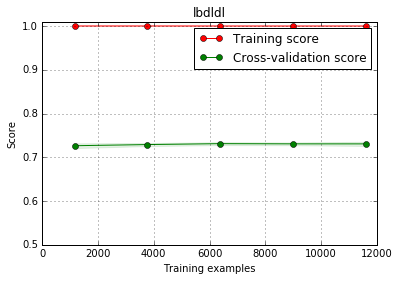

Feature ranking:
1. feature 9 (0.204682)
2. feature 4 (0.164580)
3. feature 11 (0.119426)
4. feature 7 (0.074568)
5. feature 13 (0.072039)
6. feature 2 (0.068423)
7. feature 1 (0.059426)
8. feature 8 (0.059212)
9. feature 5 (0.047000)
10. feature 10 (0.042762)
11. feature 12 (0.025922)
12. feature 3 (0.023037)
13. feature 6 (0.022890)
14. feature 0 (0.016034)


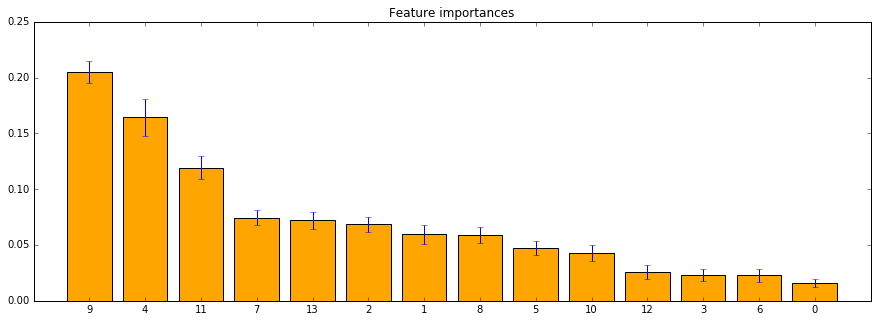

lbxsch
lbxsch
categorical
0.999844852998 on training
0.650959860384 on hold out
Accuracy: 0.653792230623 (+/- 0.00597334118884)
0.65189063409  CV HO
Predicted   0.0  1.0  2.0   All
True                           
0.0        5365  307   44  5716
1.0        1737  221   39  1997
2.0         720  145   17   882
All        7822  673  100  8595
             precision    recall  f1-score   support

        0.0       0.69      0.94      0.79      5716
        1.0       0.33      0.11      0.17      1997
        2.0       0.17      0.02      0.03       882

avg / total       0.55      0.65      0.57      8595

slope  -3.64279905168e-07


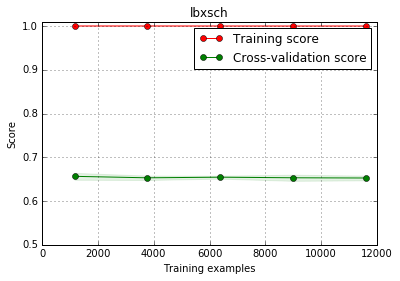

Feature ranking:
1. feature 9 (0.201922)
2. feature 4 (0.169450)
3. feature 11 (0.122485)
4. feature 7 (0.072823)
5. feature 13 (0.069711)
6. feature 2 (0.068706)
7. feature 1 (0.060565)
8. feature 8 (0.057069)
9. feature 5 (0.046517)
10. feature 10 (0.043409)
11. feature 12 (0.026357)
12. feature 6 (0.024848)
13. feature 3 (0.019803)
14. feature 0 (0.016334)


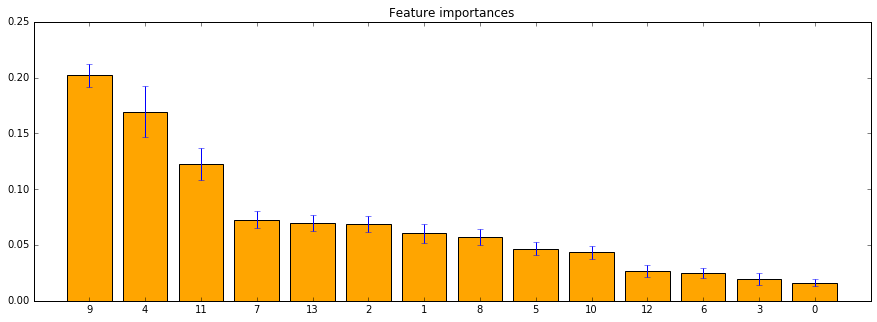

lbxsgl
lbxsca
lbxstr
lbxstr
categorical
0.999844852998 on training
0.791855730076 on hold out
Accuracy: 0.795903582225 (+/- 0.00310503684727)
0.789994182664  CV HO
Predicted   0.0  1.0  2.0   All
True                           
0.0        6772   37   30  6839
1.0         968   14    9   991
2.0         746   15    4   765
All        8486   66   43  8595
             precision    recall  f1-score   support

        0.0       0.80      0.99      0.88      6839
        1.0       0.21      0.01      0.03       991
        2.0       0.09      0.01      0.01       765

avg / total       0.67      0.79      0.71      8595

slope  -2.22735503817e-08


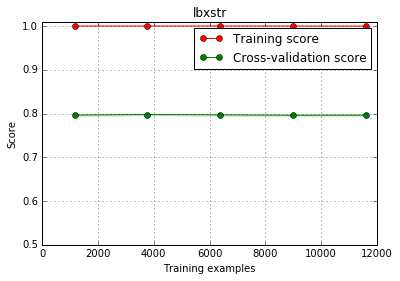

Feature ranking:
1. feature 9 (0.226584)
2. feature 4 (0.148446)
3. feature 11 (0.114859)
4. feature 2 (0.073825)
5. feature 7 (0.073369)
6. feature 13 (0.068994)
7. feature 8 (0.059975)
8. feature 1 (0.054839)
9. feature 10 (0.046883)
10. feature 5 (0.042376)
11. feature 12 (0.027003)
12. feature 3 (0.025101)
13. feature 6 (0.022344)
14. feature 0 (0.015403)


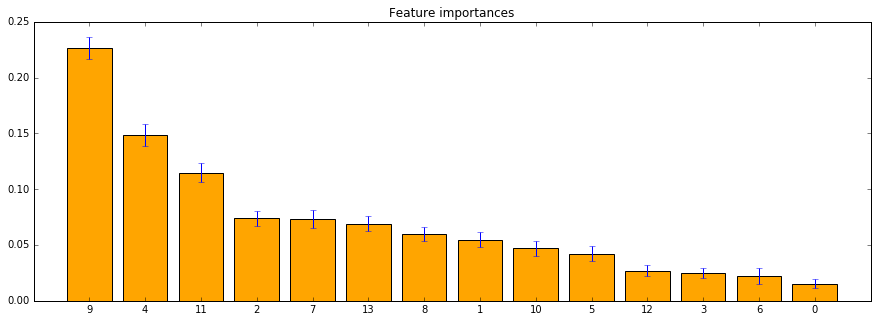

LBXIN
LBXIN
categorical
0.999767279497 on training
0.766375799884 on hold out
Accuracy: 0.764096893472 (+/- 0.00939066875364)
0.754043048284  CV HO
Predicted   0.0   1.0   All
True                       
0.0         782  1477  2259
1.0         637  5699  6336
All        1419  7176  8595
             precision    recall  f1-score   support

        0.0       0.55      0.35      0.43      2259
        1.0       0.79      0.90      0.84      6336

avg / total       0.73      0.75      0.73      8595

slope  7.05778412683e-07


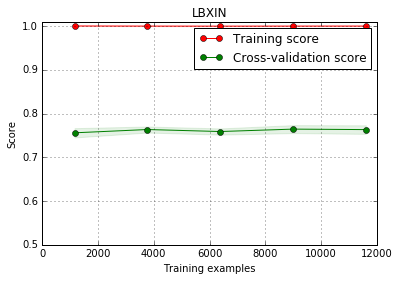

Feature ranking:
1. feature 9 (0.338645)
2. feature 4 (0.132776)
3. feature 11 (0.091750)
4. feature 2 (0.067998)
5. feature 13 (0.063324)
6. feature 7 (0.056927)
7. feature 8 (0.044528)
8. feature 5 (0.044061)
9. feature 1 (0.043664)
10. feature 10 (0.040019)
11. feature 12 (0.025099)
12. feature 3 (0.020954)
13. feature 6 (0.018445)
14. feature 0 (0.011811)


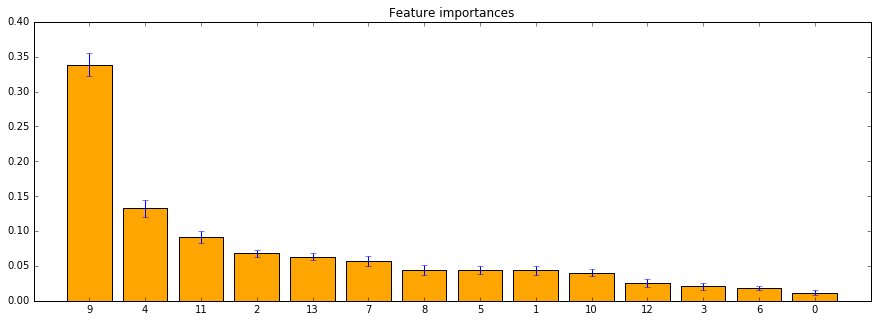

BPXDI1
BP
BP
categorical
0.999844852998 on training
0.585573007563 on hold out
Accuracy: 0.581414289875 (+/- 0.00701830406291)
0.584060500291  CV HO
Predicted   0     1     2    3   All
True                                
0           0   119    21    1   141
1          13  3759   845  140  4757
2           4  1298  1038  233  2573
3           0   330   571  223  1124
All        17  5506  2475  597  8595
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       141
          1       0.68      0.79      0.73      4757
          2       0.42      0.40      0.41      2573
          3       0.37      0.20      0.26      1124

avg / total       0.55      0.58      0.56      8595

slope  5.2036533991e-07


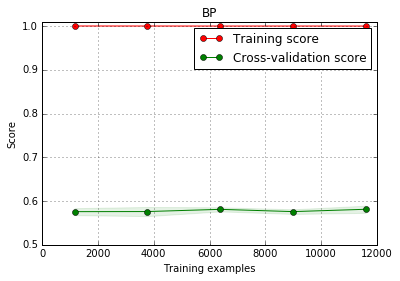

Feature ranking:
1. feature 9 (0.209238)
2. feature 4 (0.201382)
3. feature 11 (0.109496)
4. feature 2 (0.073418)
5. feature 7 (0.065628)
6. feature 13 (0.059174)
7. feature 1 (0.055429)
8. feature 8 (0.051439)
9. feature 5 (0.044757)
10. feature 10 (0.042683)
11. feature 3 (0.027153)
12. feature 12 (0.023821)
13. feature 6 (0.021077)
14. feature 0 (0.015303)


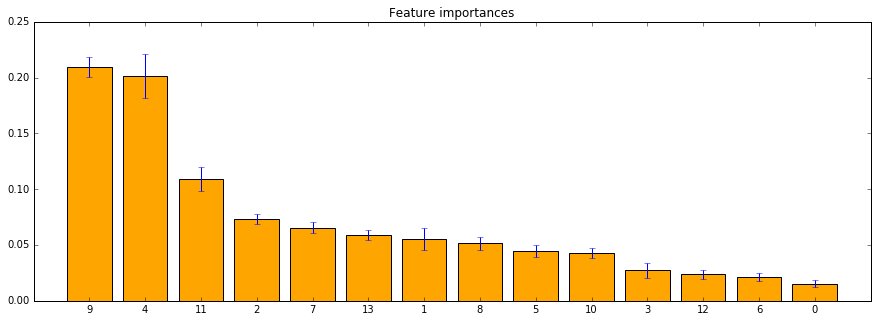

BPXPLS
BPXSY1
lbxsir


In [1849]:

## split up the data
categories = True
roc_scores = {}
RF_scores = {}
# var_dict = {}
for dependent in model_data_dict:
    print dependent
    feature_list = model_data_dict[dependent].drop([dependent,'SEQN'], axis=1).columns.tolist()
    temp_list = []
    
    Y = np.array(model_data_dict[dependent][dependent])
    X = np.array(model_data_dict[dependent].drop([dependent,'SEQN'], axis=1))
    
    validation_size = 0.4
    seed = 1
    X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y, \
                                                                test_size=validation_size, random_state=seed)
#     Y_validation = Y_train
#     X_validation = X_train
    ### could do cross validation with all data
    if categories:
        if dependent in cat_list:
            print dependent
    #         print '\n'
            print "categorical"
            model = RandomForestClassifier(n_estimators=100, min_samples_split=2,min_samples_leaf=1,\
                                           n_jobs=-1, max_features='auto', random_state=seed)
            RF_main_model = model
            model.fit(X_train, Y_train) 
            print model.score(X_train,Y_train), 'on training'
            predicted = model.predict(X_validation)
            ho_score = model.score(X_validation, Y_validation)
            print ho_score, 'on hold out'
            
            score = cross_val_score(model, X_train, Y_train, cv=10)
            print("Accuracy: %s (+/- %s)" % (score.mean(), score.std()))
            RF_scores[dependent] = [{'HO':ho_score, "CV":score}]
#             print pd.crosstab(Y_validation, predicted, rownames=['True'], colnames=['Predicted'], margins=True)
#             print 'cv'
            cv_predict = cross_val_predict(model, X_validation,Y_validation, cv=10)
            print accuracy_score(Y_validation, cv_predict), " CV HO"
        
#             print accuracy_score(Y_validation, cv_predict, normalize=False), " CV HO, count"
#             print f1_score(Y_validation, cv_predict, average='weighted'), "F1 score"
            
#             print cross_val_score(model, X, Y, cv=10).mean(), "all the data"
#             cv_predict_all = cross_val_predict(model, X,Y, cv=10)
#             print pd.crosstab(Y, cv_predict_all, rownames=['True'], colnames=['Predicted'], margins=True)
#             print 'end all test'
            print pd.crosstab(Y_validation, cv_predict, rownames=['True'], colnames=['Predicted'], margins=True)
            print(classification_report(Y_validation, cv_predict))
            plot_learning_curve(model, dependent, X_train, Y_train, ylim=(0.5, 1.01), cv=10, n_jobs=4)
#             roc_curve_plot(X,Y, dependent, RF_main_model) 

#             print temp_list
            feature_importance(model, X, feature_list, dependent, show_ranking=True,\
                                                   csv=True, show_plot=True)


#     else:
#         print dependent
#         print "linear"
#         model = RandomForestRegressor()  
#     #     model = PLSRegression(n_components=1)
        
#         model.fit(X_train, Y_train) 
#         print model.score(X_train,Y_train), "R^2"
# #         prediction = model.predict(X_validation)
#         mse = regr_acc(X_validation, Y_validation, model) ## my own function for mean sqrd error and variance
#         score = cross_val_score(model, X_train, Y_train, cv=10, scoring='neg_mean_squared_error').mean()
#         print score
#         cv_predict = cross_val_predict(model, X_validation,Y_validation)
#         mse = np.mean((cv_predict- Y_validation) ** 2)
#         RF_scores[dependent] = [{'HO':mse, "CV":score}]
#         feature_importance(model, X)

#     print accuracy_score(prediction,Y_validation)

#     print type(X), type(Y)
#     # prepare models
#     models = []
#     models.append(('RF', RandomForestRegressor()))
#     models.append(('PLS', PLSRegression(n_components=1)))
#     models.append(('KR', KernelRidge(alpha=1.0)))
#     models.append(('LR', LinearRegression()))
    
    
    # evaluate each model in turn
#             num_folds = 10
#             num_instances = len(X_train)
#             seed = 7
#             scoring = 'accuracy'
#             models = []
#             models.append(('LR', LogisticRegression()))
# #             models.append(('LDA', LinearDiscriminantAnalysis()))
# #             models.append(('KNN', KNeighborsClassifier()))
# #             models.append(('CART', DecisionTreeClassifier()))
# #             models.append(('NB', GaussianNB()))
# #             models.append(('SVM', SVC()))
#             # evaluate each model in turn
#             results = []
#             names = []
#             for name, model in models:
#                 kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
#                 cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
#                 results.append(cv_results)
#                 names.append(name)
#                 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#                 print(msg)
#                 print sigmoid( dot([val1, val2], lr.coef_) + lr.intercept_ ) 
#                 print model.fit(X_train,Y_train).predict_proba(X_validation)
#                 pca = PCA(n_components=2)
#                 cls = LogisticRegression() 
#                 pipe = Pipeline([('pca', pca), ('logistic', clf)])
#                 pipe.fit(X_train, Y_train)
#                 predictions = pipe.predict(X_validation)
#                 print accuracy_score(Y_validation, predictions)
#                 print pipe.score(X_validation, Y_validation)
                
    # boxplot algorithm comparison
#     fig = plt.figure()
#     fig.suptitle('Algorithm Comparison')
#     ax = fig.add_subplot(111)
#     plt.boxplot(results)
#     ax.set_xticklabels(names)
#     plt.show()
#     break

In [1652]:
print RF_scores

{'lbdldl': [{'HO': 0.72809773123909249, 'CV': 0.7287264239076553}], 'lbxsch': [{'HO': 0.64653868528214076, 'CV': 0.65154164164252049}], 'BP': [{'HO': 0.58357518592417923, 'CV': 0.59989055129227542}], 'lbxstr': [{'HO': 0.78987783595113437, 'CV': 0.79613710343125288}], 'LBXIN': [{'HO': 0.76009307737056431, 'CV': 0.76611456375892328}]}


In [ ]:
'''
Default
lbdldl
categorical
0.718861209964 on hold out
Accuracy: 0.71 (+/- 0.00)
LR: 0.735909 (0.007158)
LDA: 0.736014 (0.006932)
KNN: 0.704350 (0.007298)
lbxsch
categorical
0.637429348964 on hold out
Accuracy: 0.63 (+/- 0.00)
LR: 0.661381 (0.008607)
LDA: 0.661329 (0.007788)
KNN: 0.630607 (0.007509)
lbxstr
categorical
0.776219384551 on hold out
Accuracy: 0.78 (+/- 0.00)
LR: 0.798972 (0.009357)
LDA: 0.798658 (0.009168)
KNN: 0.780236 (0.008511)

min_samples_leaf=50
lbdldl
categorical
0.746284278836 on hold out
Accuracy: 0.74 (+/- 0.00)
lbxsch
categorical
0.674481892401 on hold out
Accuracy: 0.66 (+/- 0.00)
lbxstr
categorical
0.790663596399 on hold out
Accuracy: 0.80 (+/- 0.00)

100 estimators
lbdldl
categorical
0.737910822692 on hold out
Accuracy: 0.73 (+/- 0.00)
lbxsch
categorical
0.653757588445 on hold out
Accuracy: 0.65 (+/- 0.00)
lbxstr
categorical
0.785639522713 on hold out
Accuracy: 0.79 (+/- 0.00)

Default
lbdldl
Predicted   0.0  1.0  2.0   All
True                           
0.0        3492   61   12  3565
1.0         805   28    3   836
2.0         362   14    0   376
All        4659  103   15  4777
lbxsch
Predicted   0.0  1.0  2.0   All
True                           
0.0        3024  175   23  3222
1.0         946  123   21  1090
2.0         394   65    6   465
All        4364  363   50  4777
lbxstr
Predicted   0.0  1.0  2.0   All
True                           
0.0        3743   21   13  3777
1.0         556    6    5   567
2.0         427    4    2   433
All        4726   31   20  4777


min leaf 100
lbdldl
categorical
Predicted   0.0   All
True                 
0.0        3565  3565
1.0         836   836
2.0         376   376
All        4777  4777
lbxsch
Predicted   0.0   All
True                 
0.0        3222  3222
1.0        1090  1090
2.0         465   465
All        4777  4777
lbxstr
Predicted   0.0   All
True                 
0.0        3777  3777
1.0         567   567
2.0         433   433
All        4777  4777


Notes:
- First istead of getting rid of outliers, I made them 'na', then afterwords computed the mean replacement
- Seems Logit might be best
- Tried manipulating RF model, with leaf sample size and estimators and other things
- tried PCA and logit, worse off
- looked at learning curve and decided to reduce the amount of NA's by only keeping only 2000 of the least NA rows
  -- get rid of outliers
  -- get rid of columns with < 40% of data
  -- do mean replacement of NA's on all columns
  
- since we dont need a lot of data changed the training size to 40% in order to have a more robust predictions score
-removed any features with > 50% correlations

- very high correlation between ldl and totchl 0.76695075 
'''

In [1174]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    RF_main_model, X, Y, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RF")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

ValueError: Invalid parameter gamma for estimator RandomForestClassifier. Check the list of available parameters with `estimator.get_params().keys()`.

In [1732]:
## ROC curve

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

def roc_curve_plot(X,Y, dependent, model):
    # Binarize the output
    y = label_binarize(Y, classes=[0, 1, 2])
    if dependent == 'BP':
        y = label_binarize(Y, classes=[0, 1, 2, 3])
    n_classes = y.shape[1]

    # shuffle and split training and test sets
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=.8,
                                                        random_state=0)

#     model = RandomForestClassifier()
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, Y_train).predict_proba(X_validation)


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_validation[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    if dependent == 'BP':
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))


    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class  -'+dependent)
    plt.legend(loc="lower right")
    plt.show()

# roc_curve_plot(X,Y, dependent)   

'''
'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.
'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
'''

"\n'micro':\nCalculate metrics globally by counting the total true positives, false negatives and false positives.\n'macro':\nCalculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.\n"

In [1807]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print "slope ", (test_scores_mean[0] - test_scores_mean[-1]) / (train_sizes[0] - train_sizes[-1])
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
#     return plt

# title=dependent
# cv = ShuffleSplit(n_splits=10, test_size=0.4, random_state=0)
# plot_learning_curve(RF_main_model, title, X_train, Y_train, ylim=(0, 1.01), cv=cv, n_jobs=4)
# plt.show()


In [ ]:
def plot12(y, predicted):
    ax = fig.add_subplots()
    ax.scatter(y, predicted)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    plt.show()

In [ ]:
dependent = 'lbxsgl'
feature_list = model_data_dict[dependent].drop([dependent,'SEQN'], axis=1).columns.tolist()
Y = np.array(model_data_dict[dependent][dependent])
X = np.array(model_data_dict[dependent].drop([dependent,'SEQN'], axis=1))
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y, \
                                                                test_size=validation_size, random_state=seed)
y = Y_validation
model.fit(X_train, Y_train) 
predicted = model.predict(X_validation)

print "hold out"
fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

model = RandomForestRegressor() 
# y = Y_train
# predicted = cross_val_predict(model, X_train, Y_train, cv=10)
predicted = cross_val_predict(model, X_validation, Y_validation, cv=10)


print "cross val"
fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [1848]:
def feature_importance(model, X, feature_list, dependent, show_ranking=True, csv=False, show_plot=True):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
#     print feature_list[1]
    # Print the feature ranking
    print("Feature ranking:")
    temp = []
    temp1 = []
    temp2 = []
    for f in range(X.shape[1]):
        if show_ranking:
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        temp.append(importances[indices[f]])
        temp1.append(indices[f])
        temp2.append(feature_list[indices[f]])
            
    if csv:
        df = pd.DataFrame()
        df[dependent+'_importance_rank'] = range(1,len(temp1)+1)
        df['feature'] = temp1
        df['important_score'] = temp
        df['name'] = temp2
        
        df.to_csv(dependent+'_feature_importance.csv', index=False)

    # Plot the feature importances of the forest
    plt.figure(figsize=(15,5))
#     ax = fig.add_subplot()
#     plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="orange", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    if show_plot:
        plt.show()
    
    return temp2
# feature_importance(model, X, feature_list, dependent, ranking=True, csv=False)

In [349]:
# # Test options and evaluation metric
# num_folds = 10 # 5 or 10 does not really change
# num_instances = len(X_train)
# seed = 7
# scoring = 'accuracy'

In [361]:
## PLS regression
PLS_scores = {}
for dependent in model_data_dict:
    print dependent
    if 'cat' in dependent:
        categories = True
        dependent = dependent[:dependent.find('_cat')]
    else:
        categories = False
    feature_list = model_data_dict[dependent].drop([dependent,'SEQN'], axis=1).columns.tolist()
#     print model_data_dict[dependent][dependent].head()
    Y = np.array(model_data_dict[dependent][dependent])
    X = np.array(model_data_dict[dependent].drop([dependent,'SEQN'], axis=1))
    
    validation_size = 0.20
    seed = 7
    X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y, \
                                                                test_size=validation_size, random_state=seed)
    pls2 = PLSRegression(n_components=1)
    # pls2.fit(X_train, Y_train)
    # PLSRegression(copy=True, max_iter=500, n_components=2, scale=True,
    #         tol=1e-06)
    # Y_pred = pls2.predict(X_validation)
    x,y = pls2.fit_transform(X_train, Y_train)
    # pls2.fit(x, y)
#     print pls2.get_params(deep=True)
    mse = regr_acc(X_validation, Y_validation, pls2) 
    score = cross_val_score(pls2, X_train, Y_train, cv=10, scoring='neg_mean_squared_error').mean()
    print score
    cv_predict = cross_val_predict(pls2, X_validation,Y_validation)
    mse = np.mean((cv_predict- Y_validation) ** 2)
    PLS_scores[dependent] = [{'HO':mse, "CV":score}]


lbdldl
Mean squared error: 1142.06
Variance score: 0.05
-913.699534189
lbxsch
Mean squared error: 2059.65
Variance score: -0.29
-1607.47468218
lbxsgl
Mean squared error: 436.53
Variance score: -1.23
-342.506539958
lbxsca
Mean squared error: 0.25
Variance score: -0.84
-0.200363847264
lbxstr
Mean squared error: 3652.24
Variance score: -0.15
-3007.87759916
LBXIN
Mean squared error: 86.77
Variance score: -0.65
-78.4147145006
lbxsir
Mean squared error: 1224.81
Variance score: -0.15
-1092.05936859


In [362]:
print 'rf'
print RF_scores
print 'pls'
print PLS_scores

rf
{'lbdldl': [{'HO': 1039.8927041173981, 'CV': -1006.4356018414852}], 'lbxsch': [{'HO': 1290.7724980386906, 'CV': -1263.5298719578661}], 'lbxsgl': [{'HO': 144.48448521533257, 'CV': -157.82880507613655}], 'lbxsca': [{'HO': 0.11963963912376542, 'CV': -0.11485489034169068}], 'lbxstr': [{'HO': 2577.0402812855555, 'CV': -2801.5379074985217}], 'LBXIN': [{'HO': 61.508824630924828, 'CV': -63.762009250496476}], 'lbxsir': [{'HO': 1096.8635840252352, 'CV': -1098.0911764645582}]}
pls
{'lbdldl': [{'HO': 1270.7816667108098, 'CV': -913.69953418888849}], 'lbxsch': [{'HO': 1593.0345682175723, 'CV': -1607.4746821822866}], 'lbxsgl': [{'HO': 428.42767507491266, 'CV': -342.5065399575933}], 'lbxsca': [{'HO': 0.2407476031190913, 'CV': -0.20036384726364589}], 'lbxstr': [{'HO': 3932.6172682466208, 'CV': -3007.8775991553339}], 'LBXIN': [{'HO': 61.037680389572365, 'CV': -78.414714500638397}], 'lbxsir': [{'HO': 1229.3013776579501, 'CV': -1092.0593685866172}]}


In [100]:
## start with the models
regr = LinearRegression(fit_intercept=True, normalize=False)
# kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)

# cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
# Train the model using the training sets
regr.fit(X_train, Y_train)

predictions = regr.predict(X_validation)

m = regr.coef_
b = regr.intercept_
# print "formula: y = {0}x + {1}".format(m,b)

# print(accuracy_score(Y_validation, predictions))
## row is the thing it is actually in, in this case lots of things are thought of as 4
# print(confusion_matrix(Y_validation, predictions))
# print(classification_report(Y_validation, predictions))

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X_validation) - Y_validation) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_validation, Y_validation))

y_pred = regr.predict(X_validation)
# print y_pred
# print Y_validation
# print accuracy_score(Y_validation, y_pred)

# cv = KFold(len(X_train), 10, shuffle=True, random_state=33)

# #decf = LinearRegression.decision_function(train, target)
# test = LinearRegression.predict(X_train, Y_train)
# score = cross_val_score(regr,X_train, Y_train,cv=cv )

# print("Score: {}".format(score.mean()))

('Coefficients: \n', array([ -5.62529589e+00,  -1.12687637e-14,   4.19982494e+00,
        -6.66793809e-02,  -2.54163417e+00,   8.27219850e-01,
         4.89808510e-02,  -1.17603067e+00,   6.01857593e-01,
         8.63450144e-02,  -3.17466223e-02,  -4.14812135e+00,
         4.48066788e+00,  -8.88178420e-16,   0.00000000e+00,
         0.00000000e+00,  -3.32546531e-01,   0.00000000e+00,
         7.47039645e+00,  -7.47039645e+00,  -1.19057436e+00]))
Mean squared error: 1147.00
Variance score: 0.07


In [102]:
from sklearn.kernel_ridge import KernelRidge
n_samples, n_features = 10, 5
clf = KernelRidge(alpha=1.0)
clf.fit(X_train, Y_train) 
# KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear',
#             kernel_params=None)
regr_acc(X_validation, Y_validation, clf)
# y_kr = clf.predict(X_train)

Mean squared error: 1146.68
Variance score: 0.07


In [25]:
## random forest
model = RandomForestRegressor()
model.fit(X_train, Y_train) 
prediction = model.predict(X_validation)
# print prediction
print mean_squared_error(Y_validation, prediction)
regr_acc(X_validation, Y_validation, model)

# model = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(model, X_train, Y_train).mean()
print score
# regr_acc(X_validation, Y_validation, model)


## from article
# from sklearn.metrics import roc_curve, auc
# model = RandomForestClassifier(n_estimators=1000) 
# model.fit(X_train, Y_train) 
# disbursed = model.predict_proba(X_validation) 
# # fpr, tpr, _ = roc_curve(Y_validation, disbursed[:,1]) 
# # roc_auc = auc(fpr, tpr) 
# # print roc_auc
# predictions = model.predict(X_validation)
# print(accuracy_score(Y_validation, predictions))
# ## row is the thing it is actually in, in this case lots of things are thought of as 4
# print(confusion_matrix(Y_validation, predictions))
# print(classification_report(Y_validation, predictions))

1543.8580163
Mean squared error: 1543.86
Variance score: -0.17
-0.137081537702


['ACD010A', 'OCD150', 'OCQ180', 'DMDBORN', 'DMDEDUC2', 'DMDEDUC3', 'DMDHHSIZ', 'DMDHSEDU', 'INDFMIN2', 'RIDAGEYR', 'DMDMARTL_Married', 'DMDMARTL_Never_married', 'RIAGENDR_Male', 'RIAGENDR_Female', 'HID010']
Feature ranking:
1. feature 9 (0.288191)
2. feature 6 (0.114767)
3. feature 7 (0.104133)
4. feature 2 (0.089177)
5. feature 8 (0.079074)
6. feature 4 (0.068807)
7. feature 5 (0.047330)
8. feature 1 (0.045086)
9. feature 14 (0.042729)
10. feature 0 (0.037655)
11. feature 12 (0.024754)
12. feature 3 (0.020457)
13. feature 10 (0.015813)
14. feature 11 (0.011734)
15. feature 13 (0.010293)


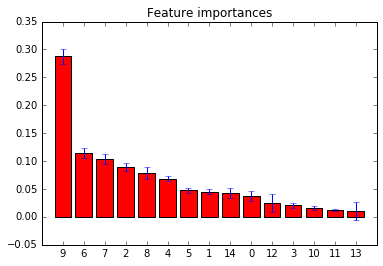

In [166]:
# importances = model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# print feature_list
# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
# plt.show()

In [451]:
# print("Mean squared error: %.2f"
#       % np.mean((y_kr - Y_validation) ** 2))
# Explained variance score: 1 is perfect prediction
# print('Variance score: %.2f' % clf.score(X_validation, Y_validation))


SyntaxError: invalid syntax (<ipython-input-451-c464883e0486>, line 5)

647.5 0.14 13.6888352529 10.08 14.8361772772
7 19970


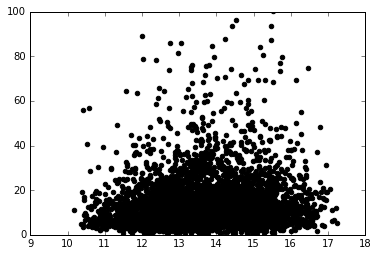

In [390]:
# print len(X_validation), len(Y_validation)
# # Plot outputs
plt.scatter(predictions, Y_validation,  color='black')
plt.ylim(0, 100)
# plt.plot(Y_validation, predictions, color='blue',
#          linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()
# # print cv_results
print max(Y_train), min(Y_train), np.mean(Y_train), np.median(Y_train), np.std(Y_train)
print len(Y_train[Y_train > 250]), len(Y_train)
# plt.hist(Y_train, bins=100, range=(0,100))
# plt.show()

ACD010A


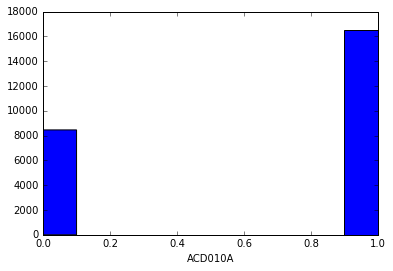

ACD010B


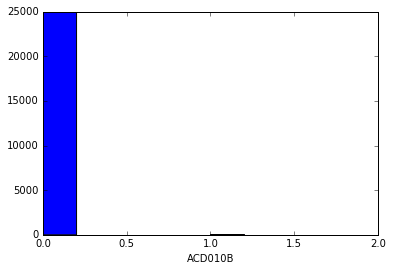

SEQN


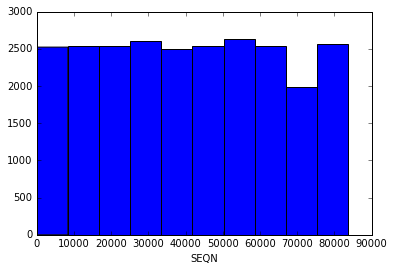

OCD150


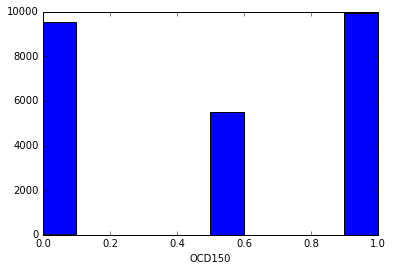

OCQ180


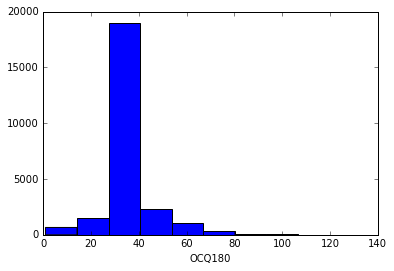

DMDBORN


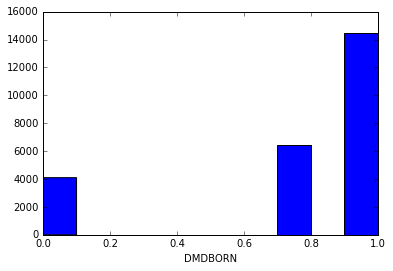

DMDEDUC2


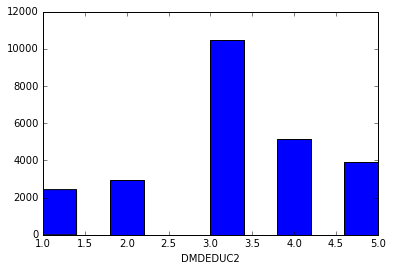

DMDEDUC3


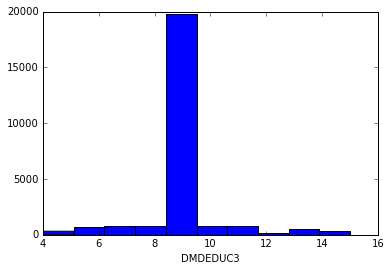

DMDHHSIZ


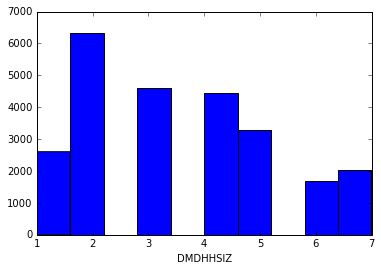

DMDHHSZA


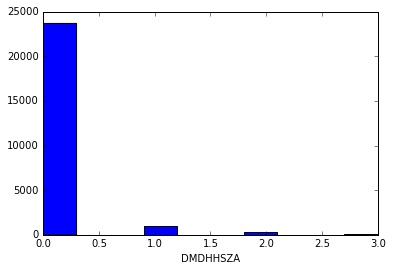

DMDHHSZB


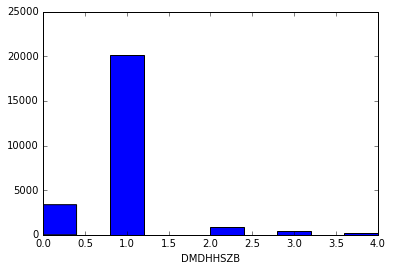

DMDHHSZE


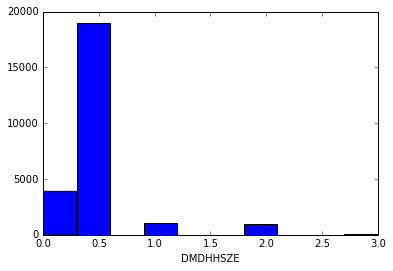

DMDHSEDU


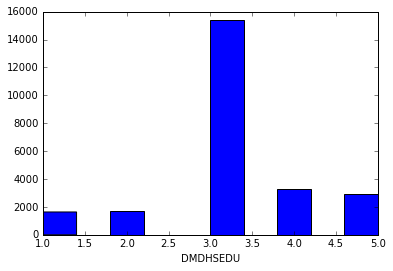

INDFMIN2


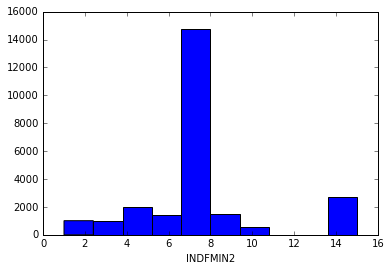

RIDAGEYR


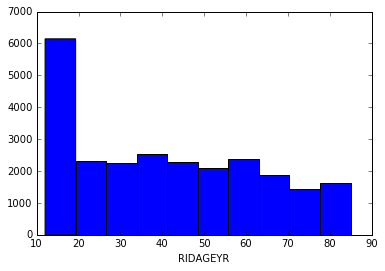

DMDMARTL_Missing


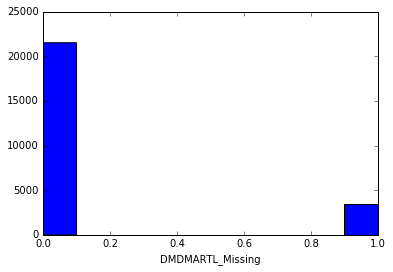

DMDMARTL_Married


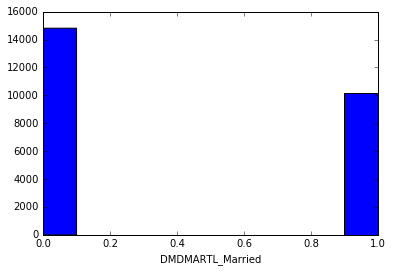

DMDMARTL_Widowed


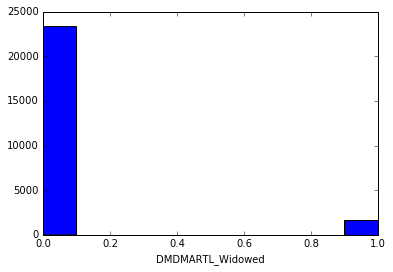

DMDMARTL_Divorced


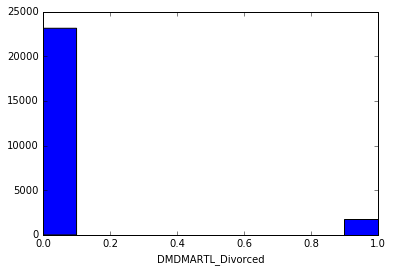

DMDMARTL_Separated


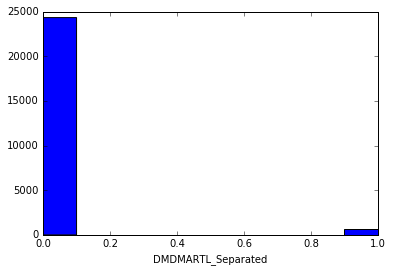

DMDMARTL_Never_married


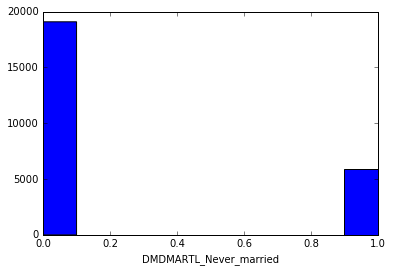

DMDMARTL_Living_with_partner


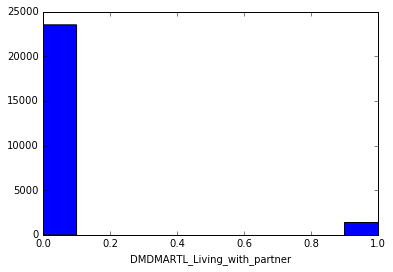

RIAGENDR_Male


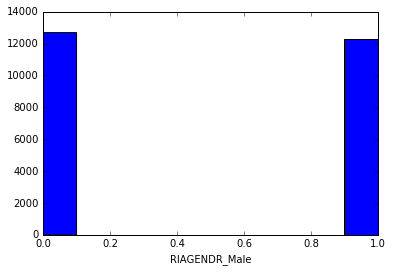

RIAGENDR_Female


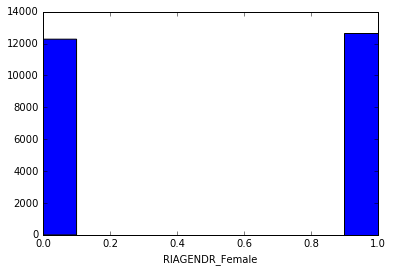

HID010


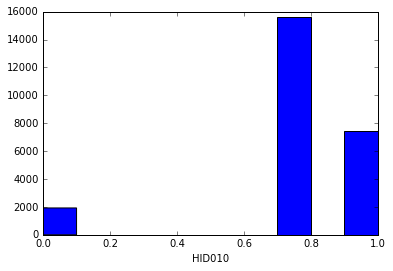

LBXIN


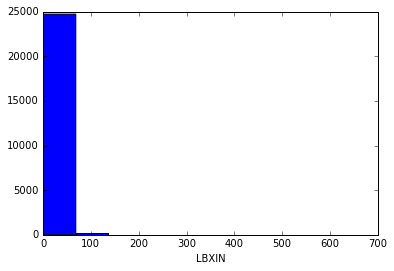

In [423]:
temp = model_data_dict[dependent]
# print temp.columns.tolist()
for i in temp.columns.tolist():
    print i
    plt.hist(temp[i])
    plt.xlabel(i)
    plt.show()

In [245]:
print model_data_dict.keys()
# print model_data_dict['L10AM']['LBXIN'].head(90)

print len(model_data_dict['L10AM']['LBXIN'])
print len(model_data_dict['L10AM'].dropna())
# model_data_dict['L10AM'].to_csv('insulin_test.csv', index=False)

['L10AM']
24963
24963


/Users/mjaron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


-0.0522267492639
ACD010A    -0.032938
ACD010B    -0.000931
SEQN        0.010658
OCD150     -0.052969
OCQ180      0.000366
DMDEDUC2   -0.056605
DMDEDUC3   -0.051344
DMDHHSIZ    0.015423
DMDHHSZA    0.006995
DMDHHSZB    0.030653
DMDHHSZE   -0.003511
DMDHSEDU   -0.067991
DMDMARTL   -0.002127
INDFMIN2   -0.052227
RIAGENDR   -0.004501
RIDAGEYR   -0.000491
HID010      0.002013
LBXIN       1.000000
Name: LBXIN, dtype: float64


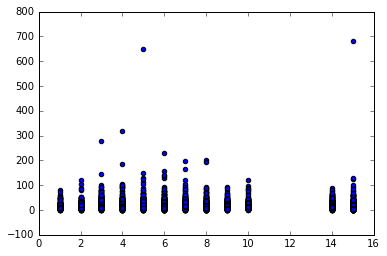

In [30]:
## correlations
df = model_data_dict['L10AM']
x = 'INDFMIN2'
y = 'LBXIN'
plt.scatter(df[x], df[y])
# plt.ylabel(y)
# plt.xlabel(x)
a = df.corr()
# print a
b = a[y].dropna()
b.sort(ascending=True, kind='quicksort', na_position='last', inplace=False)
print b[x] #dr1tsugr + dr1ttfat + dr1tcarb + dr1tprot + dr1tkcal
print b

# print master.head()
# print master['LBXIN_y'].head()
# print filt_data_dict.keys()

# print filt_data_dict['L10AM_C_2003_2004']

In [61]:
## if needed to change NaN to 0
# a = filt_data_dict['ACQ_B_2001_2002']
# a.fillna(value=0)

## proof that seqn are different for all years
print min(filt_data_dict['OCQ_1999_2000']['SEQN']), max(filt_data_dict['OCQ_1999_2000']['SEQN'])
print min(filt_data_dict['OCQ_B_2001_2002']['SEQN']), max(filt_data_dict['OCQ_B_2001_2002']['SEQN'])
print min(filt_data_dict['OCQ_C_2003_2004']['SEQN']), max(filt_data_dict['OCQ_C_2003_2004']['SEQN'])
print min(filt_data_dict['OCQ_D_2005_2006']['SEQN']), max(filt_data_dict['OCQ_D_2005_2006']['SEQN'])
print min(filt_data_dict['OCQ_E_2007_2008']['SEQN']), max(filt_data_dict['OCQ_E_2007_2008']['SEQN'])

2.0 9965.0
9966.0 21004.0
21005.0 31125.0
31130.0 41474.0
41475.0 51623.0


In [191]:
# data_dict.keys()

In [47]:
combinded_var_dict['OCQ'].describe()

,OCD150,OCQ180,SEQN
count,45050.000000,25549.000000,52355.000000
mean,0.500200,39.360132,40946.475255
std,0.500006,15.063494,24355.038199
min,0.000000,1.000000,2.000000
25%,NaN,NaN,19602.000000
50%,NaN,NaN,41300.000000
75%,NaN,NaN,61452.000000
max,1.000000,133.000000,83729.000000


In [89]:
master.head()

,ACD010A,ACD010B,SEQN,OCD150,OCQ180,DMDBORN,DMDEDUC2,DMDEDUC3,DMDHHSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHSEDU,DMDMARTL,INDFMIN2,RIAGENDR,RIDAGEYR,HID010
0,1.0,0.0,73557.0,0.0,NaN,1.0,3.0,NaN,3.0,5.397605e-79,5.397605e-79,2.000000e+00,NaN,4.0,4.0,1.0,69.0,NaN
1,1.0,0.0,73558.0,1.0,50.0,1.0,3.0,NaN,4.0,5.397605e-79,2.000000e+00,5.397605e-79,1.0,1.0,7.0,1.0,54.0,NaN
2,1.0,0.0,73559.0,0.0,NaN,1.0,4.0,NaN,2.0,5.397605e-79,5.397605e-79,2.000000e+00,3.0,1.0,10.0,1.0,72.0,NaN
3,1.0,0.0,73560.0,NaN,NaN,1.0,NaN,3.0,4.0,5.397605e-79,2.000000e+00,5.397605e-79,4.0,NaN,9.0,1.0,9.0,NaN
4,1.0,0.0,73561.0,0.0,NaN,1.0,5.0,NaN,2.0,5.397605e-79,5.397605e-79,2.000000e+00,5.0,1.0,15.0,2.0,73.0,NaN


In [99]:
combinded_var_dict.keys()

['OCQ', 'DEMO', 'ACQ', 'L10AM', 'HIQ']

In [44]:
a = filt_data_dict['DEMO_F_2009_2010']['DMDEDUC3']
print a.describe()
a = a.fillna(0)
a = list(a)
print {x:a.count(x) for x in a}

count    2.595000e+03
mean     6.277457e+00
std      6.135838e+00
min      5.397605e-79
25%               NaN
50%               NaN
75%               NaN
max      9.900000e+01
Name: DMDEDUC3, dtype: float64
{0.0: 7942, 5.3976053469340279e-79: 239, 2.0: 211, 3.0: 222, 4.0: 213, 5.0: 193, 6.0: 165, 7.0: 185, 8.0: 166, 9.0: 155, 10.0: 193, 11.0: 185, 12.0: 36, 13.0: 94, 14.0: 13, 15.0: 95, 99.0: 1, 66.0: 11, 1.0: 216, 55.0: 2}


In [409]:
var_dict['OCD150']
# 0.284399062605 DMDHHSZA 5974 24963 0.239314184994
# 0.815701372615 DMDHHSZB 5974 24963 0.239314184994
# 0.52109139605 DMDHHSZE 5974 24963 0.239314184994
# 3.33677031745 DMDHSEDU 12317 24963 0.493410247166
# 7.76969215842 INDFMIN2 11337 24963 0.454152145175

{'file': 'OCQ',
 'ind_dep': 'independent',
 'label': 'Type of work done last week',
 'var_type': 'na',
 'year': '1999-2014'}

In [1771]:
# master['OCD150'].describe()
# combinded_var_dict.keys()

a = 10
b = 5
c/=b
print c

0        2.040000
1        3.520000
2        2.720000
3        1.240000
4        0.920000
5        1.960000
6        6.040000
7        2.560000
8        4.280000
9        3.320000
10       4.160000
11       4.282753
12       7.000000
13       6.200000
14       4.282753
15       2.920000
16       2.600000
17       3.120000
18       2.280000
19       4.400000
20       2.480000
21       3.160000
22       9.800000
23       3.680000
24       2.240000
25       3.840000
26       1.800000
27       4.040000
28       3.480000
29       4.080000
           ...   
21456    4.200000
21457    2.480000
21458    3.640000
21459    2.160000
21460    6.360000
21461    7.280000
21462    1.440000
21463    2.720000
21464    4.282753
21465    3.960000
21466    1.240000
21467    1.760000
21468    3.320000
21469    3.840000
21470    3.240000
21471    1.440000
21472    1.840000
21473    3.960000
21474    1.920000
21475    4.440000
21476    4.320000
21477    1.760000
21478    3.200000
21479    5.480000
21480    3

In [1843]:
print range(1,10+1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
